[Colab](https://colab.research.google.com/github/dominik-strutz/Endurance_CCS_design_study/blob/main/endurance_design_study.ipynb)

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False


if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        ! pip install --quiet zuko
        ! pip install --quiet cartopy
        ! pip install --quiet git+https://github.com/dominik-strutz/GeoBED.git
        ! pip install --quiet ax-platform
        ! pip install --quiet git+https://github.com/sgrubas/NES.git

        # ! pip install --quiet obspy
        # clean up working directory
        ! rm -rf *

        ! git clone --quiet https://github.com/dominik-strutz/Endurance_CCS_design_study tmp
        ! mv tmp/* .
        ! rm -rf tmp
        dependencies_installed = True

In [2]:
import os
import contextlib

import torch
import torch.distributions as dist
import zuko

import tensorflow as tf
from tqdm.keras import TqdmCallback

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')

from tqdm.notebook import tqdm

import xarray as xr
import pandas as pd

import cartopy
import cartopy.crs as ccrs
from cartopy.geodesic import Geodesic

2023-08-31 16:09:43.232457: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from helper_functions import *

In [4]:
from endurance_setup_layered import *

Loaded model from "NES-TP_Model_endurance_BGS_layered"


In [5]:
print(seismic_inventory)

            lat       lon  elevation  rms_noise
CWF   52.738499 -1.307670      203.0        0.3
EDMD  54.831200 -1.963600      337.0        0.3
ELMS  52.093330  0.989500       74.0        1.3
GDLE  54.421830 -0.815670      228.0        1.1
HPK   53.958172 -1.624168      233.0        0.8
LBWR  53.401600 -1.724698      353.0        0.8
LMK   53.457298 -0.327400      133.0        1.3
WACR  52.724602  0.626600       66.0        1.3


# Geographic Setting

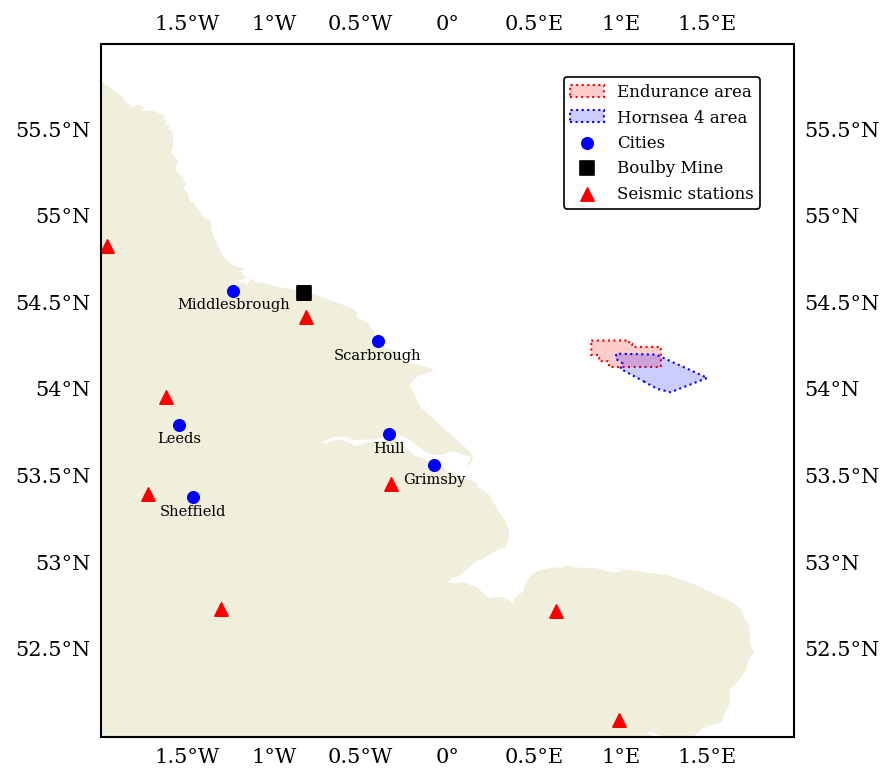

In [6]:
projPC = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection=projPC))

plot_geographic_settings(
    ax, lon_min, lon_max, lat_min, lat_max,
    landmarks_df, endurance_area_latlon, hornsea_4_latlon,
    seismic_inventory, projPC,
    add_land=True)

plt.show()

# Topography

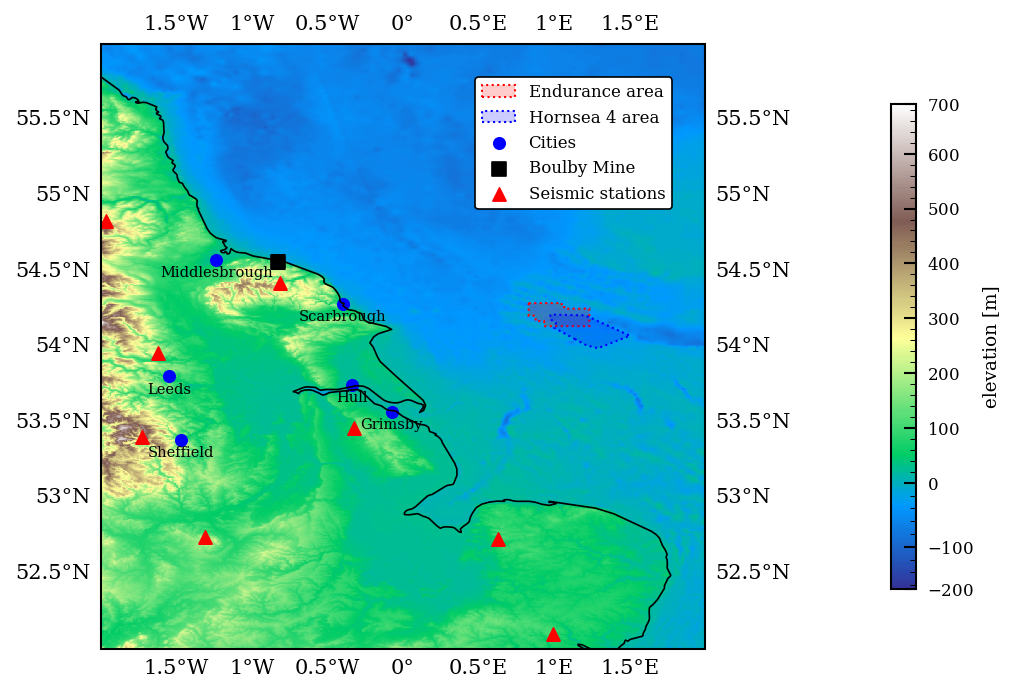

In [7]:

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=projPC))

plot_geographic_settings(
    ax, lon_min, lon_max, lat_min, lat_max,
    landmarks_df, endurance_area_latlon, hornsea_4_latlon,
    seismic_inventory, projPC,
    add_coastlines=True)

norm = FixPointNormalize(sealevel=0, vmin=np.nanmin(topo_data_latlon), vmax=np.nanmax(topo_data_latlon))
im = xr.plot.imshow(
    topo_data_latlon, cmap='terrain', x='lon', y='lat', xlim=(lon_min, lon_max), ylim=(lat_min, lat_max),
    norm=norm, vmin=np.nanmin(topo_data_latlon), vmax=np.nanmax(topo_data_latlon),
    add_colorbar=False)

fig.colorbar(im, label='elevation [m]', shrink=0.7, ax=ax, pad=0.2,)

ax.set_aspect('equal')

plt.show()

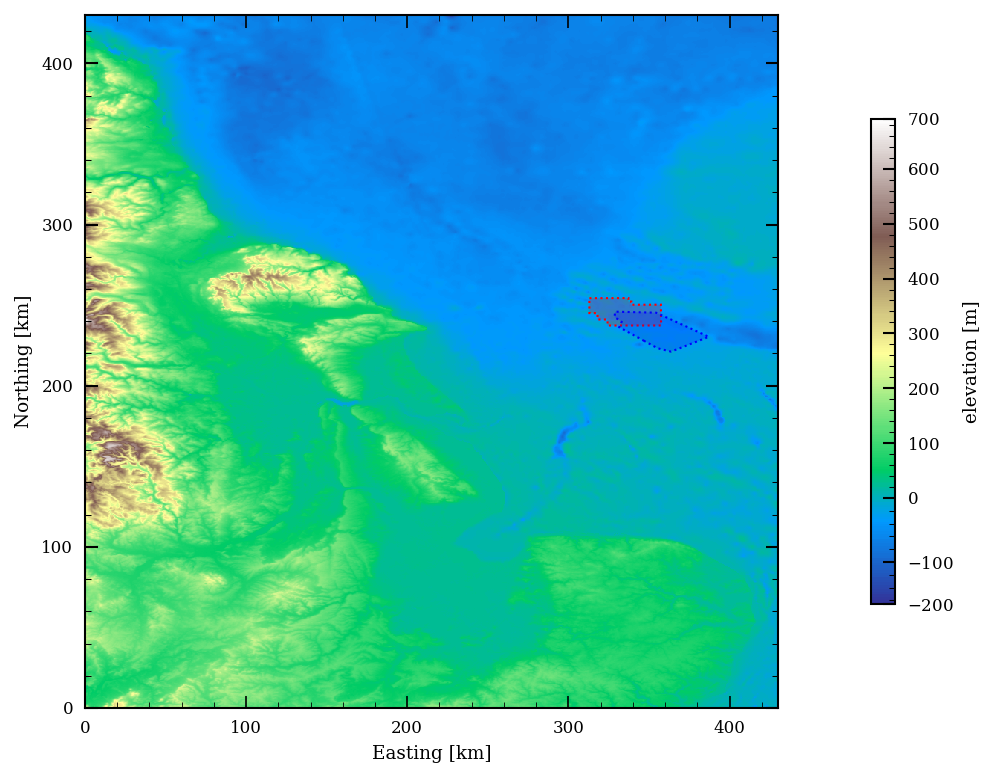

In [8]:


fig, ax = plt.subplots(figsize=(8, 6))

# plot_geographic_settings(
#     ax, lon_min, lon_max, lat_min, lat_max,
#     landmarks_df, endurance_area_latlon, hornsea_4_latlon,
#     seismic_inventory, projPC,
#     add_coastlines=True)

norm = FixPointNormalize(sealevel=0, vmin=np.nanmin(topo_data_xy), vmax=np.nanmax(topo_data_xy))
im = xr.plot.imshow(
    topo_data_xy, cmap='terrain', x='E', y='N', #xlim=(local_lon_min, local_lon_max), ylim=(local_lat_min, local_lat_max),
    norm=norm, vmin=np.nanmin(topo_data_xy), vmax=np.nanmax(topo_data_xy),
    add_colorbar=False)

ax.fill(
    endurance_area_xy[:, 0], endurance_area_xy[:, 1],
    facecolor=(1,0,0,.2),
    edgecolor=(1,0,0, 1), linewidth=1.0, linestyle=':',
    label='Endurance area',
)

ax.fill(
    hornsea_4_xy[:, 0], hornsea_4_xy[:, 1],
    facecolor=(0,0,1,.2),
    edgecolor=(0,0,1, 1), linewidth=1.0, linestyle=':',
    label='Hornsea 4 area',
)

ax.set_xlim(0, 430_000)
ax.set_ylim(0, 430_000)

ax.set_xticks(np.linspace(0, 400_000, 5))
ax.set_yticks(np.linspace(0, 400_000, 5))

ax.set_xticklabels([f'{v/1000:.0f}' for v in ax.get_xticks()])
ax.set_yticklabels([f'{v/1000:.0f}' for v in ax.get_yticks()])

ax.set_xlabel('Easting [km]')
ax.set_ylabel('Northing [km]')

fig.colorbar(im, label='elevation [m]', shrink=0.7, ax=ax, pad=0.1,)
ax.set_aspect('equal')

plt.show()

# Seismic Model

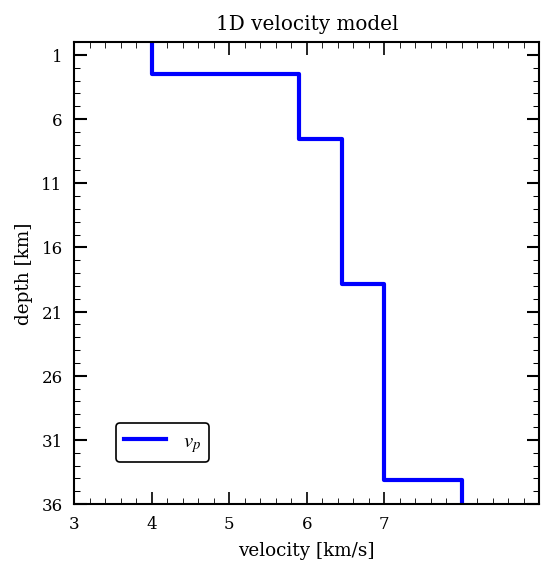

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.step(Vel.v, -np.array(Vel.z.tolist()+[50000.,]), 'b', linewidth=2, label=r'$v_p$')

ax.set_ylim(-36000, 0)
ax.set_xlim(3000, 9000)

ax.set_xticks(np.arange(3000, 8000, 1000))
ax.set_yticks(np.arange(-36000, 0, 5000))

ax.set_xticklabels([f'{v/1000:.0f}' for v in ax.get_xticks()])
ax.set_yticklabels([f'{-v/1000:.0f}' for v in ax.get_yticks()])

ax.set_xlabel('velocity [km/s]')
ax.set_ylabel('depth [km]')

ax.set_title('1D velocity model')

ax.legend(loc='lower left', fontsize=10)

plt.show()

# Inversion Tests

In [10]:
from geobed.continuous.core import BED_Class

def data_likelihood(samples, design=None, **kwargs):
    cov_matrix = torch.eye(samples.shape[-1]) * design[:, -1] * 0.5 \
        + torch.eye(samples.shape[-1]) * (samples.mean(list(range(samples.dim()-1)))*0.005)**2
    return dist.MultivariateNormal(samples, covariance_matrix=cov_matrix)


Forward_Class = Endurance_Traveltimes(filepath_eikonal_nn, topo_data_xy.values)

Test_BED_Class = BED_Class(
    forward_function=Forward_Class,
    obs_noise_dist=data_likelihood,
    m_prior_dist=prior_dist,
    )

In [11]:
design_seis_only = seismic_inventory.to_numpy()
design_seis_only[:, :2] = seismic_stations_xy[:, :2]
design_seis_only = torch.from_numpy(design_seis_only).float()
# design_seis_only[:, 2] = -1 * design_seis_only[:, 2]

n_visual_model_samples = int(1e4)

clean_data = Test_BED_Class.get_forward_function_samples(
    design_seis_only,
    n_samples_model=n_visual_model_samples,
    n_samples_nuisance=1,
    random_seed_model=1,
    random_seed_nuisance=2,
    ).squeeze()

noisy_data = Test_BED_Class.get_forward_model_samples(
    design_seis_only,
    n_samples_model=n_visual_model_samples,
    n_samples_nuisance=1,
    random_seed_model=1,
    random_seed_nuisance=2,
    ).squeeze() 

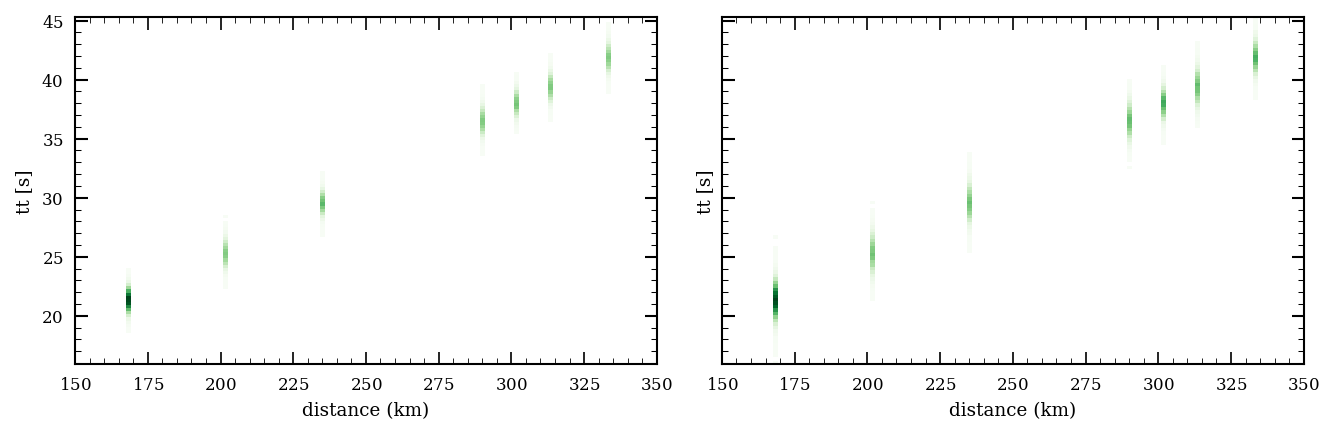

In [12]:
# with style.context('./mpl_stylesheet.mplstyle'):
fig = plt.figure(figsize=(9, 3))
ax_dict = fig.subplot_mosaic(
    '''ab''',
    # gridspec_kw={'wspace': 0.2},
    sharex=True, sharey=True)

ax_dict['a'].hist2d(
    np.sqrt((design_seis_only.squeeze()[:, 1].expand(n_visual_model_samples, -1).flatten().numpy()-wells_coords_xy[0, 1])**2 + \
    (design_seis_only.squeeze()[:, 0].expand(n_visual_model_samples, -1).flatten().numpy()-wells_coords_xy[0, 0])**2)/1e3,
    clean_data.flatten().numpy(),
    bins=[100, 100], cmap='Greens', cmin=1)

ax_dict['b'].hist2d(
    np.sqrt((design_seis_only.squeeze()[:, 1].expand(n_visual_model_samples, -1).flatten().numpy()-wells_coords_xy[0, 1])**2 + \
    (design_seis_only.squeeze()[:, 0].expand(n_visual_model_samples, -1).flatten().numpy()-wells_coords_xy[0, 0])**2)/1e3,
    noisy_data.flatten().numpy(),
    bins=[100, 100], cmap='Greens', cmin=1)
    

for ax in ax_dict.values():
    ax.set_xlim(150, 350)
    ax.set_ylabel('tt [s]')
    ax.set_xlabel('distance (km)')

plt.tight_layout()
plt.show()

In [13]:
def prepare_input_data(model_samples, design):
    receivers = design[:, :3]
    inp_indices = np.indices((model_samples.shape[0], receivers.shape[0])).reshape(2, -1).T
    inp = np.hstack((model_samples[inp_indices[:,0]], receivers[inp_indices[:,1]]))    
    return inp


def gridsearch_posterior(tt_obs, x, y, z, design, eikonal_nn, prior_dist, data_likelihood):
    p_posterior_X, p_posterior_Y, p_posterior_Z = torch.meshgrid(x, y, z, indexing='ij')
    posterior_grid = torch.stack([p_posterior_X, p_posterior_Y, p_posterior_Z], axis=-1)
    posterior_grid_flat = posterior_grid.flatten(end_dim=-2)

    inp = prepare_input_data(posterior_grid_flat, design)

    posterior_tt = torch.from_numpy(eikonal_nn.Traveltime(inp, verbose=0))
    posterior_tt = posterior_tt.reshape(posterior_grid.shape[0], posterior_grid.shape[1], posterior_grid.shape[2], design.shape[0])
    
    p_likelihood = data_likelihood(posterior_tt, design).log_prob(tt_obs)
    
    p_prior = prior_dist.log_prob(posterior_grid)

    p_unnormalised_posterior = p_likelihood + p_prior
    
    p_evidence = torch.logsumexp(p_unnormalised_posterior, dim=(0,1,2))

    p_posterior = p_unnormalised_posterior - p_evidence
    
    return p_posterior, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z

In [14]:
true_event = torch.tensor([335.0, 245.0, -1.02]) *1e3

N_grid_posterior = 50

local_x_min, local_x_max = 315_000, 350_000
local_y_min, local_y_max = 235_000, 260_000
local_z_min, local_z_max = -3_000, 0

x_local = torch.linspace(local_x_min, local_x_max, N_grid_posterior)
y_local = torch.linspace(local_y_min, local_y_max, N_grid_posterior)
z_local = torch.linspace(local_z_min, local_z_max, N_grid_posterior)

inp = prepare_input_data(true_event.unsqueeze(0), design_seis_only)

tt_obs = torch.from_numpy(Eik_nn.Traveltime(inp, verbose=0))

p_posterior, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z = gridsearch_posterior(tt_obs, x_local, y_local, z_local, design_seis_only, Eik_nn, prior_dist, data_likelihood)


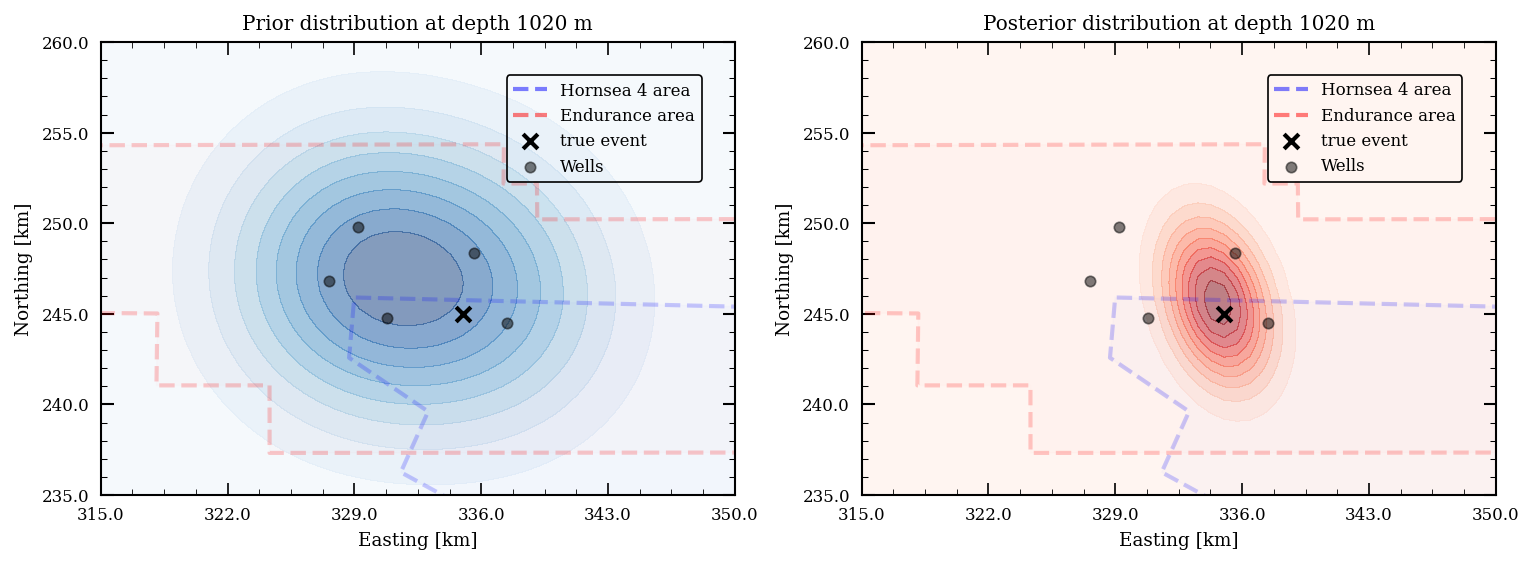

In [15]:
from helper_functions import plot_modelspace_dist_slice

depth = true_event[2]

fig, ax_dict = plt.subplot_mosaic([['a', 'b']], figsize=(12, 6))

ax = ax_dict['a']

plot_modelspace_dist_slice(
    ax, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local,
    slice_axis='z', slice_value=depth,
    contour_kwargs={'levels': 10, 'cmap': 'Blues', 'alpha': 0.5, 'zorder': 0},
    hornsea = hornsea_4_xy,
    endurance = endurance_area_xy,
    wells=wells_coords_xy,
    true_event=true_event,
    )

ax.set_title(f'Prior distribution at depth {-depth:.0f} m')


ax = ax_dict['b']

plot_modelspace_dist_slice(
    ax, p_posterior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local, 
    slice_axis='z', slice_value=depth,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.5, 'zorder': 0},
    hornsea = hornsea_4_xy,
    endurance = endurance_area_xy,
    wells=wells_coords_xy,
    true_event=true_event,)

ax.set_title(f'Posterior distribution at depth {-depth:.0f} m')


plt.show()

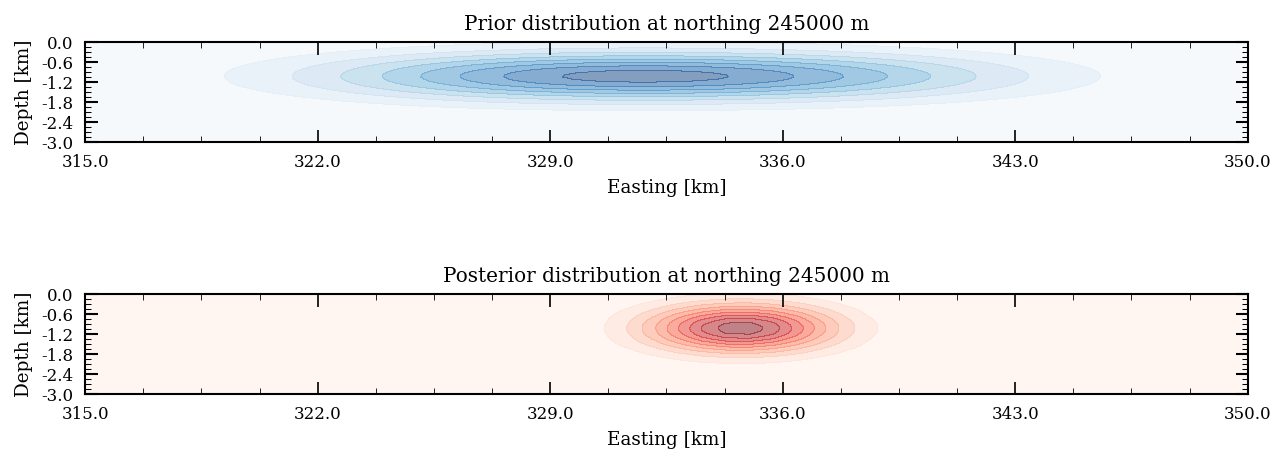

In [16]:
N_slice = true_event[1]

fig, ax_dict = plt.subplot_mosaic([['a'],['b']], figsize=(10, 4))

ax = ax_dict['a']

plot_modelspace_dist_slice(
    ax, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local,
    slice_axis='N', slice_value=N_slice,
    contour_kwargs={'levels': 10, 'cmap': 'Blues', 'alpha': 0.5, 'zorder': 0},)

ax.set_title(f'Prior distribution at northing {N_slice:.0f} m')

ax = ax_dict['b']

plot_modelspace_dist_slice(
    ax, p_posterior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local, 
    slice_axis='N', slice_value=N_slice,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.5, 'zorder': 0},)

ax.set_title(f'Posterior distribution at northing {N_slice:.0f} m')


plt.show()

# Noise Level Boulby Mine Design

In [17]:
avg_surface_seis_noise = design_seis_only[:, -1].mean()
print(f'Average surface seismic noise: {avg_surface_seis_noise:.2f} s')

mine_latlon = np.array([landmarks_df['lat']['Boulby Mine'], landmarks_df['lon']['Boulby Mine']])[None, :]
mine_xy = latlong2xy(mine_latlon[:, 0], mine_latlon[:, 1], topo_data_latlon)
mine_depth = -1400

mine_relative_noise_level = np.logspace(1, -3, 21)

design_list_mine_noise = []

for nl_i in mine_relative_noise_level:

    design_i = design_seis_only.clone()
    boulby_data = torch.tensor([mine_xy[0, 0], mine_xy[0, 1], mine_depth, avg_surface_seis_noise*nl_i])
    
    design_i = torch.cat((design_i, boulby_data[None, :]), dim=0)    
    
    design_list_mine_noise.append(design_i)
    
design_list_mine_noise = torch.stack(design_list_mine_noise).float()

Average surface seismic noise: 0.90 s


In [18]:
T = int(1e4)

eig_nmc, out_nmc = Test_BED_Class.calculate_EIG(
    design=design_list_mine_noise,
    eig_method='NMC',
    eig_method_kwargs={
        'N': T,
        # 'M': M,
        'reuse_M':True,
        'memory_efficient':True},
    num_workers=5,
    # parallel_library='joblib',
    random_seed=1,
    filename='data/mine_noise_level_comparison/endurance_mine_noise_level_nmc',
)

In [19]:
T = int(1e4)

eig_dn, out_dn = Test_BED_Class.calculate_EIG(
    design=design_list_mine_noise,
    eig_method='DN',
    eig_method_kwargs={'N': T, },
    num_workers=5,
    # parallel_library='joblib',
    random_seed=1,
    filename='data/mine_noise_level_comparison/endurance_mine_noise_level_dn',
)

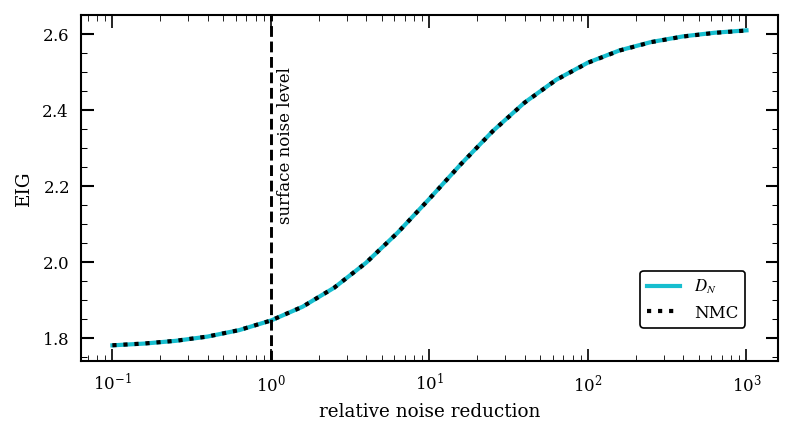

In [20]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)

ax.plot(1/mine_relative_noise_level, eig_dn, label=r"$D_N$", color="tab:cyan", linestyle="-", linewidth=2)
ax.plot(1/mine_relative_noise_level, eig_nmc, label="NMC", color="black", linestyle=":", linewidth=2)

ax.axvline(1, color="black", linestyle="--")
ax.text(1.1, ax.get_ylim()[1]-0.15*(ax.get_ylim()[1]-ax.get_ylim()[0]), "surface noise level", rotation=90, verticalalignment="top", fontsize=8)

ax.set_xlabel("relative noise reduction")
ax.set_ylabel("EIG")

# ax.set_xlim(0.1, 1000)
# ax.set_ylim(1.5, 2.1)

ax.set_xscale("log")

ax.legend(loc="lower right", fontsize=8)

plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

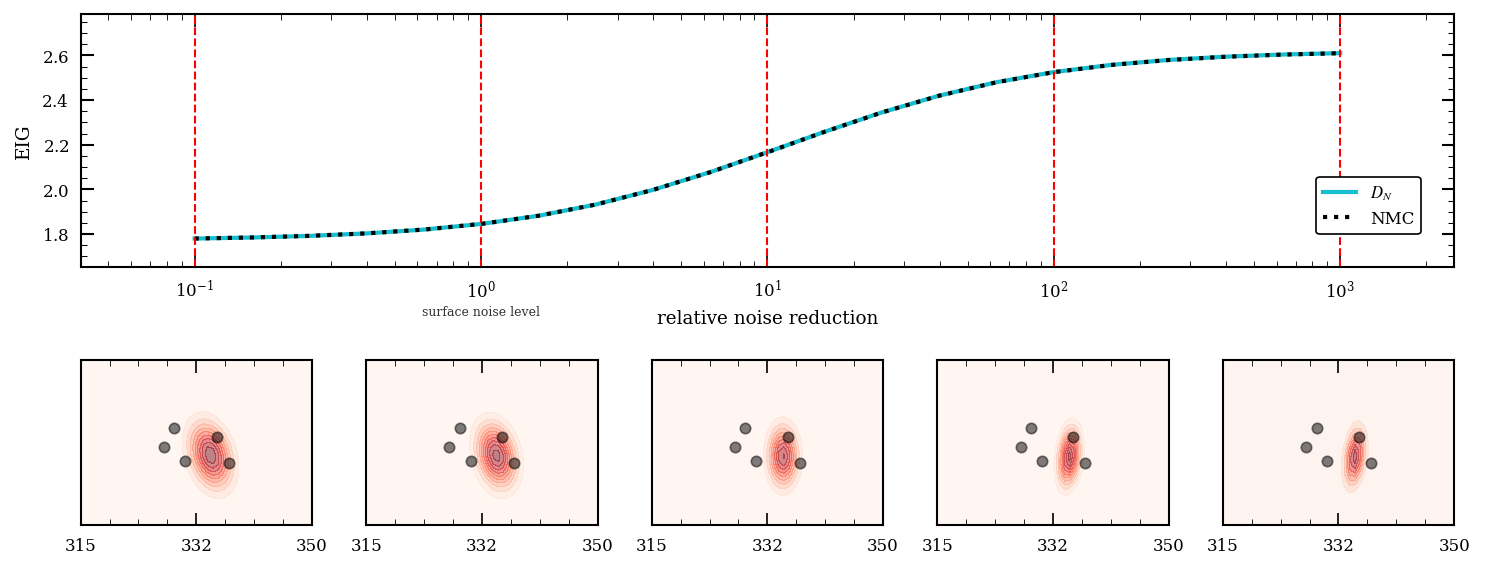

In [21]:
posterior_indicies = ['0', '5', '10', '15', '20']

fig, ax_dict = plt.subplot_mosaic([['a', 'a', 'a', 'a', 'a'],
                                   posterior_indicies      ],
                                  figsize=(10, 4),)

ax = ax_dict['a']

ax.plot(1/mine_relative_noise_level, eig_dn, label=r"$D_N$", color="tab:cyan", linestyle="-", linewidth=2)
ax.plot(1/mine_relative_noise_level, eig_nmc, label="NMC", color="black", linestyle=":", linewidth=2)

ax.set_ylim(ax.get_ylim()[0]*0.95, ax.get_ylim()[1]*1.05)

# ax.axvline(1, color="black", linestyle="--")
ax.text(
    1.0, ax.get_ylim()[0]-0.15*(ax.get_ylim()[1]-ax.get_ylim()[0]), "surface noise level", rotation=0,
    verticalalignment="top", horizontalalignment='center',
    fontsize=6, clip_on=False, alpha=0.8)

ax.set_xlabel("relative noise reduction")
ax.set_ylabel("EIG")

ax.set_xlim(0.1*0.4, 1000*2.5)

ax.set_xscale("log")

ax.legend(loc="lower right", fontsize=8, frameon=True, facecolor='white', framealpha=1)

for i in tqdm(range(5)):
    ax = ax_dict[posterior_indicies[i]]
    
    design_i = int(posterior_indicies[i])
    relative_noise_level = mine_relative_noise_level[design_i]
    
    ax_dict['a'].axvline(1/relative_noise_level, ymin=0.0, ymax=1.0, clip_on=False,  
                         color='red', linestyle='--', linewidth=1)
        
    filename = f'data/mine_noise_level_comparison/endurance_mine_noise_level_posterior_comparison_{design_i}'
    
    if os.path.exists(filename):
        out = torch.load(filename)
    else:   
        inp = prepare_input_data(true_event.unsqueeze(0), design_list_mine_noise[design_i])
        tt_obs = torch.from_numpy(Eik_nn.Traveltime(inp, verbose=0))
        out = gridsearch_posterior(tt_obs, x_local, y_local, z_local, design_list_mine_noise[design_i],
                                   Eik_nn, prior_dist, data_likelihood)
        torch.save(out, filename)

    p_posterior, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z = out
    
    plot_modelspace_dist_slice(
    ax, p_posterior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local, 
    slice_axis='z', slice_value=depth,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.5, 'zorder': 0},
    # hornsea = hornsea_4_xy,
    # endurance = endurance_area_xy,
    wells=wells_coords_xy,
    # true_event=true_event,
    )
    
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    ax.set_xticks(np.linspace(local_x_min, local_x_max, 3))
    ax.set_xticklabels([f'{v/1000:.0f}' for v in ax.get_xticks()])
    
    # if i == 0:
    #     ax.set_yticks(np.linspace(local_y_min, local_y_max, 3))
    #     ax.set_yticklabels([f'{v/1000:.0f}' for v in ax.get_yticks()])
    # else:
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    ax.get_legend().remove()

    # ax.set_title(f'{1/relative_noise_level:.1f}')
    
    try:
        ax_dict['0'].sharey(ax)
    except:
        pass
    
    
plt.tight_layout()
plt.show()

# OBS Sensor Optimisation

In [22]:
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import init_notebook_plotting, render

ax_client = AxClient(verbose_logging=False)

x_min, x_max = topo_data_xy.coords['E'].values.min(), topo_data_xy.coords['E'].values.max()
y_min, y_max = topo_data_xy.coords['N'].values.min(), topo_data_xy.coords['N'].values.max()

ax_client.create_experiment(
    name="endurance_obs_sensors",
    parameters=[
        {'name': 'obs_1_x', 'type': 'range', 'value_type': 'float', 'bounds': [x_min, x_max]},
        {'name': 'obs_1_y', 'type': 'range', 'value_type': 'float', 'bounds': [y_min, y_max]},
    ],
    objective_name='EIG',
)

class Optimisation_Func:
    
    def __init__(self, BED_Class, existing_design, topo_data_xy):
        self.BED_Class = BED_Class
        self.existing_design = existing_design
        self.topo_data_xy = topo_data_xy

    def __call__(self, input):
        obs_1_z = self.topo_data_xy.interp(E=input['obs_1_x'], N=input['obs_1_y'], method='linear').values    
        added_design = torch.from_numpy(np.array([[input['obs_1_x'], input['obs_1_y'], obs_1_z, 0.5]]))
        design = torch.cat((self.existing_design, added_design), dim=0).float()
        
        EIG, _ = self.BED_Class.calculate_EIG(
            design.unsqueeze(0),
            eig_method='dn',
            eig_method_kwargs={
                'N': int(1e4),
                },
            num_workers=1,
            random_seed=1,
            )
        
        return {'EIG': EIG.item()}
        

optimisation_func = Optimisation_Func(Test_BED_Class, design_seis_only, topo_data_xy)

for i in tqdm(range(25), total=25, desc='Optimising OBS sensor'):
    parameters, trial_index = ax_client.get_next_trial()    
    # Local evaluation here can be replaced with deployment to external system.
    EIG_i = optimisation_func(parameters)
    ax_client.complete_trial(trial_index=trial_index, raw_data=EIG_i)

[INFO 08-31 16:10:13] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='obs_1_x', parameter_type=FLOAT, range=[0.0, 442298.90674426977]), RangeParameter(name='obs_1_y', parameter_type=FLOAT, range=[0.0, 445008.4159561554])], parameter_constraints=[]).
[INFO 08-31 16:10:13] ax.modelbridge.dispatch_utils: Using Models.GPEI since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 08-31 16:10:13] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=2 num_trials=None use_batch_trials=False
[INFO 08-31 16:10:13] ax.modelbridge.dispatch_utils: calculated num_initialization_trials=5
[INFO 08-31 16:10:13] ax.modelbridge.dispatch_utils: num_completed_initialization_trials=0 num_remaining_initialization_trials=5
[INFO 08-31 16:10:13] ax.modelbridge.dispatch_utils: 

Optimising OBS sensor:   0%|          | 0/25 [00:00<?, ?it/s]

In [23]:
optimal_obs = ax_client.get_best_parameters()[0]

obs_1_z = topo_data_xy.interp(E=optimal_obs['obs_1_x'], N=optimal_obs['obs_1_y'], method='linear').values    
optimal_obs = torch.from_numpy(np.array([[optimal_obs['obs_1_x'], optimal_obs['obs_1_y'], obs_1_z, 0.5]]))
optimal_design = torch.cat((design_seis_only, optimal_obs), dim=0).float()

In [24]:
render(ax_client.get_contour_plot(param_x="obs_1_x", param_y="obs_1_y", metric_name="EIG"))

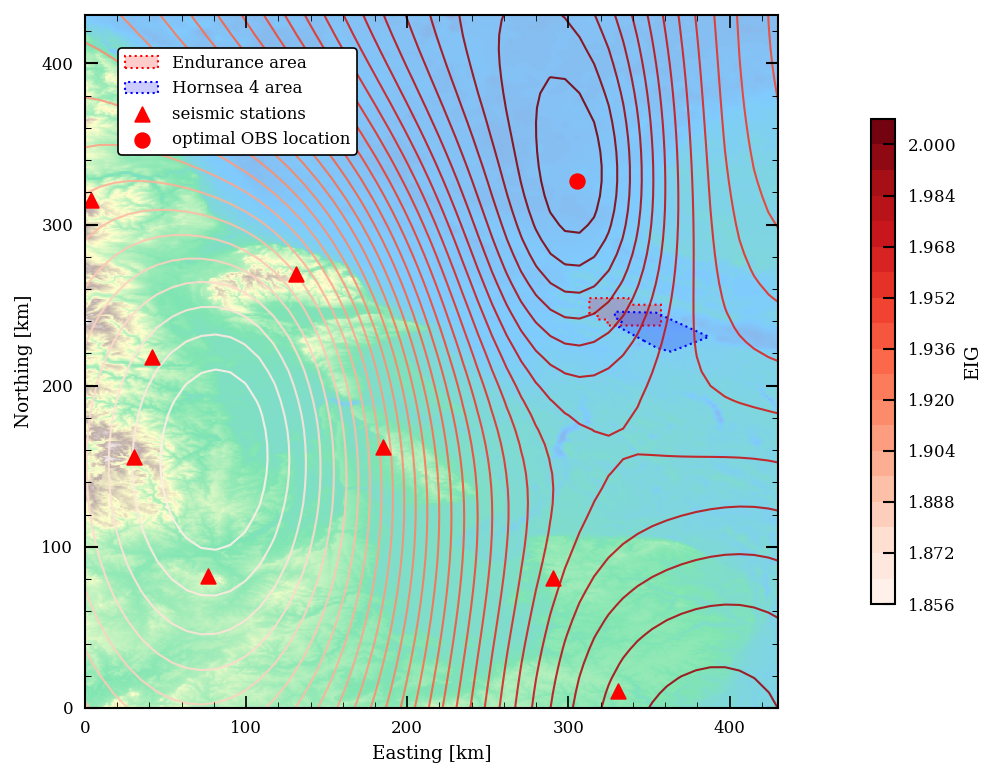

In [25]:
x = np.array(ax_client.get_contour_plot(param_x="obs_1_x", param_y="obs_1_y", metric_name="EIG").data['data'][0]['x'])
y = np.array(ax_client.get_contour_plot(param_x="obs_1_x", param_y="obs_1_y", metric_name="EIG").data['data'][0]['y'])
z = np.array(ax_client.get_contour_plot(param_x="obs_1_x", param_y="obs_1_y", metric_name="EIG").data['data'][0]['z'])


fig, ax = plt.subplots(figsize=(8, 6))

norm = FixPointNormalize(sealevel=0, vmin=np.nanmin(topo_data_xy), vmax=np.nanmax(topo_data_xy))
im = xr.plot.imshow(
    topo_data_xy, cmap='terrain', x='E', y='N', #xlim=(local_lon_min, local_lon_max), ylim=(local_lat_min, local_lat_max),
    norm=norm, vmin=np.nanmin(topo_data_xy), vmax=np.nanmax(topo_data_xy), alpha=0.5,
    add_colorbar=False)

ax.fill(
    endurance_area_xy[:, 0], endurance_area_xy[:, 1],
    facecolor=(1,0,0,.2),
    edgecolor=(1,0,0, 1), linewidth=1.0, linestyle=':',
    label='Endurance area',
)

ax.fill(
    hornsea_4_xy[:, 0], hornsea_4_xy[:, 1],
    facecolor=(0,0,1,.2),
    edgecolor=(0,0,1, 1), linewidth=1.0, linestyle=':',
    label='Hornsea 4 area',
)

ax.contour(x, y, z, levels=30, cmap='Reds', alpha=0.9, zorder=1, linewidths=1.0,)
cont = ax.contourf(x+1e6, y+1e6, z, levels=20, cmap='Reds', alpha=1.0, zorder=0)

# ax.scatter(mine_xy[:, 0], mine_xy[:, 1], marker='s', color='black', s=50, label='Boulby Mine')
ax.scatter(optimal_design[:-1, 0], optimal_design[:-1, 1], marker='^', color='red', s=50, label='seismic stations')
ax.scatter(optimal_design[-1, 0], optimal_design[-1, 1], marker='o', color='red', s=50, label='optimal OBS location')

ax.set_xlim(0, 430_000)
ax.set_ylim(0, 430_000)

ax.set_xticks(np.linspace(0, 400_000, 5))
ax.set_yticks(np.linspace(0, 400_000, 5))

ax.set_xticklabels([f'{v/1000:.0f}' for v in ax.get_xticks()])
ax.set_yticklabels([f'{v/1000:.0f}' for v in ax.get_yticks()])

ax.set_xlabel('Easting [km]')
ax.set_ylabel('Northing [km]')

fig.colorbar(cont, label='EIG', shrink=0.7, ax=ax, pad=0.1,)

ax.legend(loc='upper left', fontsize=8, frameon=True, facecolor='white', framealpha=1)

ax.set_aspect('equal')

plt.show()

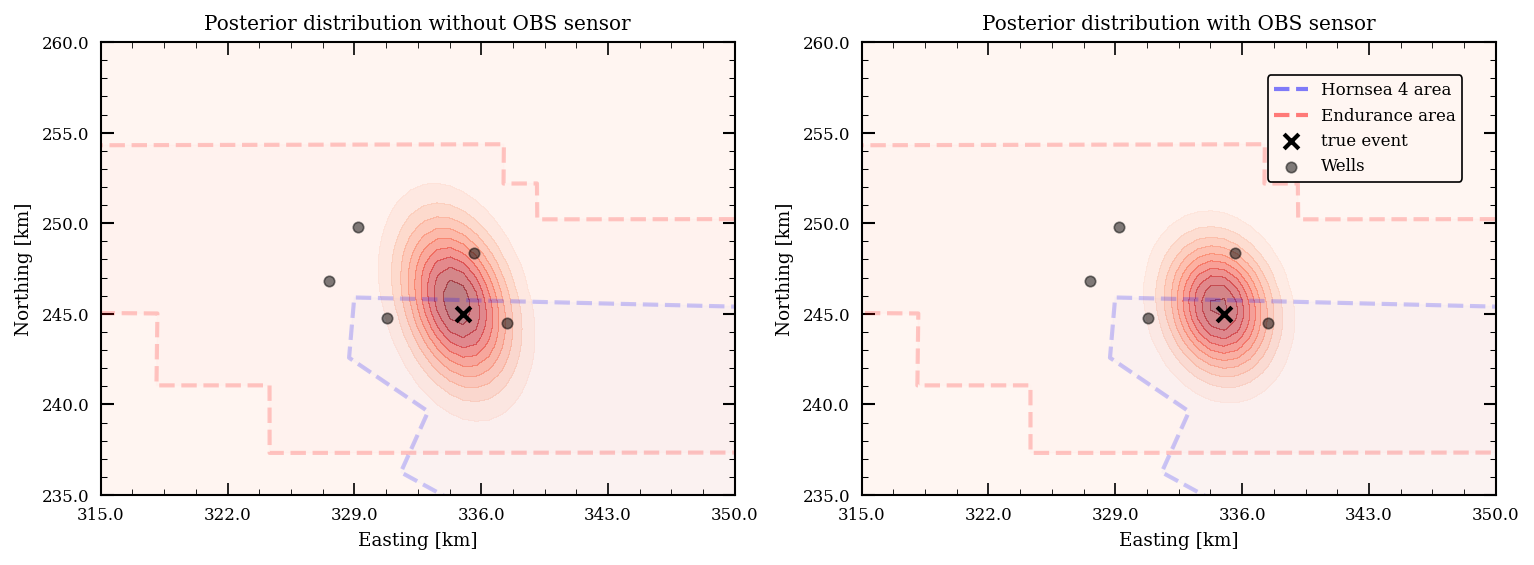

In [27]:
from helper_functions import plot_modelspace_dist_slice

depth = true_event[2]

fig, ax_dict = plt.subplot_mosaic([['a', 'b']], figsize=(12, 6))

ax = ax_dict['a']


inp = prepare_input_data(true_event.unsqueeze(0), design_seis_only)
tt_obs = torch.from_numpy(Eik_nn.Traveltime(inp, verbose=0))

p_posterior, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z = gridsearch_posterior(tt_obs, x_local, y_local, z_local, design_seis_only, Eik_nn, prior_dist, data_likelihood) 

plot_modelspace_dist_slice(
    ax, p_posterior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local,
    slice_axis='z', slice_value=depth,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.5, 'zorder': 0},
    hornsea = hornsea_4_xy,
    endurance = endurance_area_xy,
    wells=wells_coords_xy,
    true_event=true_event,
    )

ax.get_legend().remove()

ax.set_title(f'Posterior distribution without OBS sensor')


ax = ax_dict['b']

inp = prepare_input_data(true_event.unsqueeze(0), optimal_design)
tt_obs = torch.from_numpy(Eik_nn.Traveltime(inp, verbose=0))

p_posterior, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z = gridsearch_posterior(tt_obs, x_local, y_local, z_local, optimal_design, Eik_nn, prior_dist, data_likelihood)

plot_modelspace_dist_slice(
    ax, p_posterior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local, 
    slice_axis='z', slice_value=depth,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.5, 'zorder': 0},
    hornsea = hornsea_4_xy,
    endurance = endurance_area_xy,
    wells=wells_coords_xy,
    true_event=true_event,)

ax.set_title(f'Posterior distribution with OBS sensor')


plt.show()